In [139]:
#Data download and preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf     # i used here the yahoo finance library for stock price dataset


Dataset Downloading

In [98]:
# Parameters

ticker_sym = 'AAPL'         # "AAPL" is the stock ticker symbol for Apple Inc data
start = '2015-01-01'    #start date for downloading historical data
end = pd.Timestamp.today().strftime('%Y-%m-%d')              # till today's date

# Download data and select 'Close' column

df = yf.download(ticker_sym, start=start, end=end, progress=False)
df = df[['Close']].dropna()

# Ensuring the index is a DatetimeIndex and rename the column

df.index = pd.to_datetime(df.index)
df.rename(columns={'Close':'close'}, inplace=True)

df.tail()

Price,close
Ticker,AAPL
Date,
2025-09-29,254.429993
2025-09-30,254.630005
2025-10-01,255.449997
2025-10-02,257.130005
2025-10-03,258.019989


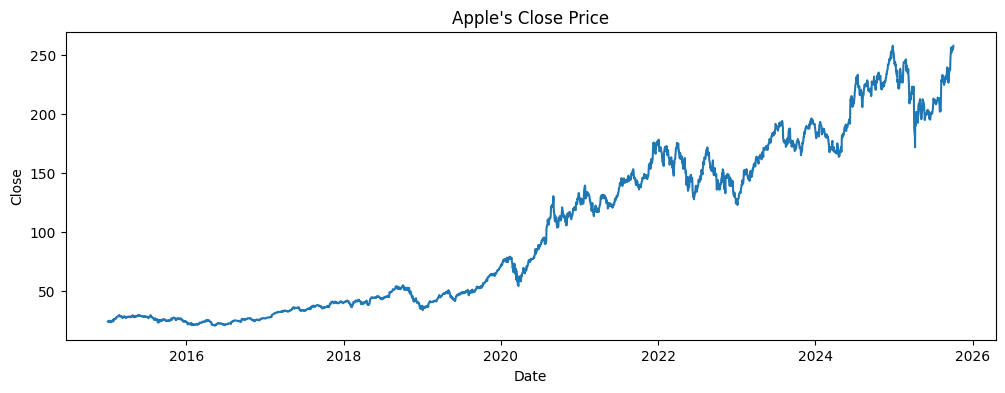

In [99]:
# Plot

plt.figure(figsize=(12,4))
plt.plot(df.index, df['close'])
plt.title('Apple\'s Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()



In [100]:
# Saving the requiredd CSV files copy

df.to_csv('orig_stock_close_price.csv')


In [101]:
#intact df
df_e=df

In [102]:
# Preparing series and splitting

series = df['close']

test_ln = 180 # last 180 days as test for baseline
train, test = series[:-test_ln], series[-test_ln:]
print('Train value length:', len(train), 'Test value length:', len(test))

Train value length: 2525 Test value length: 180


Traditional Statistical Model

In [103]:
# ARIMA (using statsmodels)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [104]:
# Fitting ARIMA

arima_model_trained = ARIMA(train, order=(5,1,0))   # (p,d,q)
arima_fitted = arima_model_trained.fit()

arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                 2525
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5242.988
Date:                Sat, 04 Oct 2025   AIC                          10497.975
Time:                        08:19:40   BIC                          10532.977
Sample:                             0   HQIC                         10510.676
                               - 2525                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0097      0.013     -0.755      0.450      -0.035       0.015
ar.L2         -0.0217      0.014     -1.578      0.114      -0.049       0.005
ar.L3         -0.0226      0.014     -1.573      0.116      -0.051       0.006
ar.L4          0.0122      0.013      0.929      0.353      -0.013       0.038
ar.L5          0.0173      0.013      1.318      0.188      -0.008       0.043
sigma2         3.7308      0.054     69.237      0.000       3.625       3.836
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3835.00
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              41.77   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
# Forecast

noOf_forecast = len(test)
arima_forecast = arima_fitted.forecast(steps=noOf_forecast)

In [106]:
# Fine-tuning the order  (p,d,q)


import itertools


# ARIMA tuning function
def func_tune_arima(series, p_range=range(0,6), d_range=range(0,3), q_range=range(0,6),
               method='aic', cv_horizon=30, verbose=True):
    best_score = float("inf")
    best_order = None

    for order in itertools.product(p_range, d_range, q_range):
        try:
            if method in ['aic','bic']:
                model = ARIMA(series, order=order)
                model_fit = model.fit()
                score = model_fit.aic if method=='aic' else model_fit.bic
            elif method=='cv':
                errors = []
                for i in range(cv_horizon, len(series)):
                    train_cv = series[:i]
                    test_cv = series[i:i+1]
                    if len(test_cv)==0:
                        break
                    model = ARIMA(train_cv, order=order)
                    model_fit = model.fit()
                    pred = model_fit.forecast(steps=1)
                    errors.append((test_cv.values[0]-pred.values[0])**2)
                score = math.sqrt(sum(errors)/len(errors))
            else:
                raise ValueError("method must be 'aic','bic', or 'cv'")

            if score < best_score:
                best_score = score
                best_order = order

            if verbose:
                print(f"Tested order {order} → score: {score:.2f}")

        except Exception as e:
            if verbose:
                print(f"Skipping order {order} due to error: {e}")
            continue

    return {'order': best_order, 'score': best_score}



In [107]:
import warnings
warnings.filterwarnings("ignore")


def rmse(a,b):
    return math.sqrt(mean_squared_error(a,b))

# Auto-tune ARIMA using AIC
print("Tuning ARIMA based on AIC...")
best_arima = func_tune_arima(train, method='aic', verbose=True)
print("Best ARIMA order:", best_arima['order'], "AIC:", best_arima['score'])

# Fit final ARIMA with best order
arima_fit = ARIMA(train, order=best_arima['order']).fit()

# Forecast test period
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast = pd.Series(arima_forecast.values, index=test.index)

# Evaluate metrics
arima_rmse = rmse(test, arima_forecast)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)
print('ARIMA RMSE:', arima_rmse, 'MAPE:', arima_mape)


Tuning ARIMA based on AIC...
Tested order (0, 0, 0) → score: 28323.20
Tested order (0, 0, 1) → score: 24923.39
Tested order (0, 0, 2) → score: 22066.49
Tested order (0, 0, 3) → score: 19753.49
Tested order (0, 0, 4) → score: 18199.75
Tested order (0, 0, 5) → score: 16871.11
Tested order (0, 1, 0) → score: 10491.87
Tested order (0, 1, 1) → score: 10493.65
Tested order (0, 1, 2) → score: 10494.41
Tested order (0, 1, 3) → score: 10495.22
Tested order (0, 1, 4) → score: 10496.64
Tested order (0, 1, 5) → score: 10497.94
Tested order (0, 2, 0) → score: 12257.27
Tested order (0, 2, 1) → score: 10493.75
Tested order (0, 2, 2) → score: 10495.44
Tested order (0, 2, 3) → score: 10495.99
Tested order (0, 2, 4) → score: 10496.60
Tested order (0, 2, 5) → score: 10498.15
Tested order (1, 0, 0) → score: 10507.80
Tested order (1, 0, 1) → score: 10509.60
Tested order (1, 0, 2) → score: 10510.38
Tested order (1, 0, 3) → score: 10511.20
Tested order (1, 0, 4) → score: 10512.61
Tested order (1, 0, 5) → sco

In [108]:
# Save ARIMA model

import joblib

joblib.dump(arima_fit, 'arima_model.pkl')


['arima_model.pkl']

In [109]:
# Forecast same length as test

n_forecast = len(test)
arima_forecast = arima_fit.forecast(steps=n_forecast)
arima_forecast = pd.Series(arima_forecast, index=test.index)

In [110]:
print("NaNs in test:", test.isna().sum())
print("NaNs in forecast:", pd.isna(arima_forecast).sum())


NaNs in test: Ticker
AAPL    0
dtype: int64
NaNs in forecast: 180


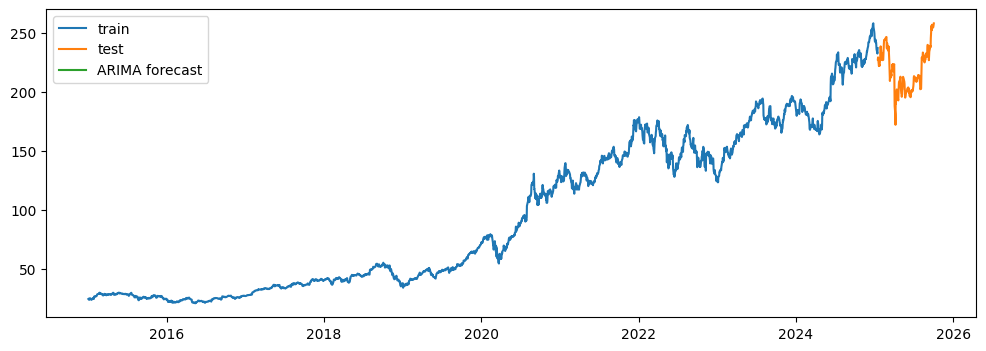

In [111]:
# Lebelling the forecast

train.index = pd.DatetimeIndex(train.index)
test.index = pd.DatetimeIndex(test.index)

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA forecast')
plt.legend()
plt.show()



Prophet Model

In [112]:
# Prophet (Facebook Prophet)

from prophet import Prophet

In [113]:
# Preparing DataFrame for Prophet model

prophet_df = train.copy().reset_index()
prophet_df.columns = ['ds', 'y']

In [114]:
# Ensuring correct types

prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')

In [115]:
# Droping any NaNs just in case

prophet_df = prophet_df.dropna(subset=['ds','y'])

prophet_df.head()

,ds,y
0,2015-01-02,24.261049
1,2015-01-05,23.577574
2,2015-01-06,23.579800
3,2015-01-07,23.910437
4,2015-01-08,24.829124


In [116]:
# Initialize and fitting Prophet

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/4rler649.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/ikgr843a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26197', 'data', 'file=/tmp/tmpqy8e9y5n/4rler649.json', 'init=/tmp/tmpqy8e9y5n/ikgr843a.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelug4grz0x/prophet_model-20251004082610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [117]:
# Save Prophet model

joblib.dump(m, 'prophet_model.pkl')


['prophet_model.pkl']

In [118]:
future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)

# Align forecast with test set
prophet_forecast = forecast.set_index('ds').reindex(test.index)['yhat'].fillna(method='ffill')


In [119]:
# Evaluation for Prophet

def rmse(a, b):
    import math
    from sklearn.metrics import mean_squared_error
    return math.sqrt(mean_squared_error(a, b))

from sklearn.metrics import mean_absolute_percentage_error
prophet_rmse = rmse(test, prophet_forecast)
prophet_mape = mean_absolute_percentage_error(test, prophet_forecast)
print('Prophet RMSE:', prophet_rmse, 'MAPE:', prophet_mape)

Prophet RMSE: 33.36221413961693 MAPE: 0.13635951207123462


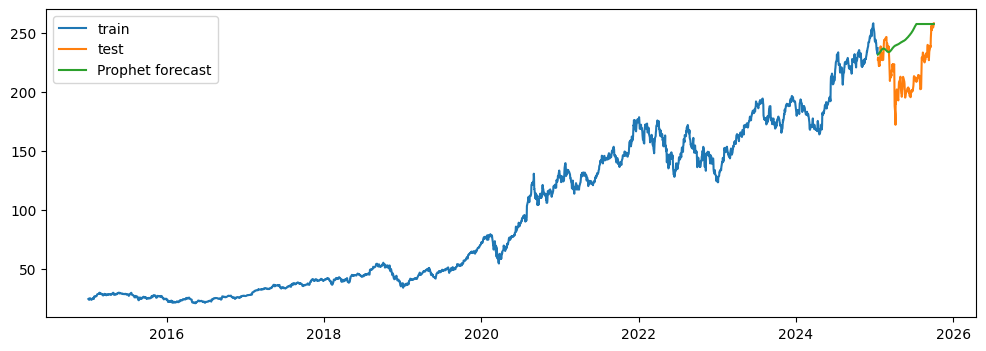

In [120]:
# Plot  for Prophet Model

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(prophet_forecast.index, prophet_forecast, label='Prophet forecast')
plt.legend()
plt.show()

LSTM Model

In [121]:
# LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

#Scale the series
scaler = MinMaxScaler(feature_range=(0,1))
scaled_series = scaler.fit_transform(series.values.reshape(-1,1))


In [122]:
# Function to create sliding windows
def create_windows(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i,0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # 3D input for LSTM
    return X, y


In [123]:
window_size = 60

# train/test datasets
X_all, y_all = create_windows(scaled_series, window_size=window_size)

# Determine split index for train/test
split_index = len(train) - window_size
X_train, y_train = X_all[:split_index], y_all[:split_index]
X_test, y_test = X_all[split_index:], y_all[split_index:]

print('LSTM X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size,1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


LSTM X_train shape: (2465, 60, 1) X_test shape: (180, 60, 1)
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0255 - val_loss: 0.0020
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - val_loss: 9.4146e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 8.2768e-04
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 7.9203e-04
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 9.7126e-04
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.

In [124]:
# Predict on test data
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

# Align predictions with test index
lstm_forecast = pd.Series(pred.flatten(), index=test.index[:len(pred)])

# Evaluation
from sklearn.metrics import mean_absolute_percentage_error

lstm_rmse = rmse(test[:len(pred)], lstm_forecast)
lstm_mape = mean_absolute_percentage_error(test[:len(pred)], lstm_forecast)
print('LSTM RMSE:', lstm_rmse, 'MAPE:', lstm_mape)




6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
LSTM RMSE: 10.225749287281012 MAPE: 0.03633924946188927


In [125]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [126]:
# Save LSTM model

# Save without full config issues
model.save("lstm_model.h5", include_optimizer=False)


In [127]:
# Save weights only in Colab
# Save weights only
model.save_weights("lstm_model.weights.h5")


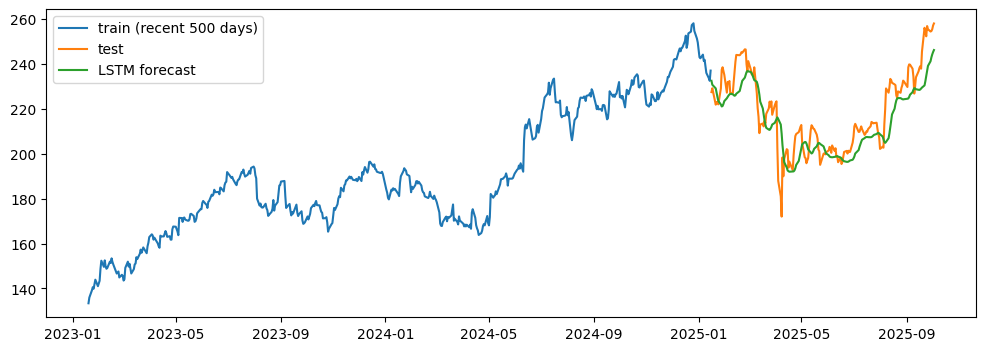

In [128]:
# Plot results for LSTM

plt.figure(figsize=(12,4))
plt.plot(train.index[-500:], train[-500:], label='train (recent 500 days)')
plt.plot(test.index, test, label='test')
plt.plot(lstm_forecast.index, lstm_forecast, label='LSTM forecast')
plt.legend()
plt.show()

 Performance Comparison Table

In [129]:
# Performance table and report (gather metrics)

import pandas as pd

# Collect metrics in a dictionary

metrics = {
    'ARIMA': {'RMSE': arima_rmse, 'MAPE': arima_mape},
    'Prophet': {'RMSE': prophet_rmse, 'MAPE': prophet_mape},
    'LSTM': {'RMSE': lstm_rmse, 'MAPE': lstm_mape}
}

metrics_df = pd.DataFrame(metrics).T

metrics_df.fillna('-', inplace=True)

metrics_df.sort_values(by='RMSE', inplace=True)

display(metrics_df)

# Save to CSV
metrics_df.to_csv('performance_table_all_models.csv', index=True)


,RMSE,MAPE
LSTM,10.225749,0.036339
ARIMA,30.990023,0.127188
Prophet,33.362214,0.136360


Rolling Window Evaluation

In [137]:
#ARIMA

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, pandas as pd
import math

def rolling_forecast_arima_sm(series, order=(5,1,0), initial_train_size=0.7, horizon=1, max_splits=20, verbose=False):

    n = len(series)
    if initial_train_size < 1:
        train_size = int(n * initial_train_size)
    else:
        train_size = int(initial_train_size)
    results = []
    splits = 0
    i = train_size

    while i + horizon <= n and splits < max_splits:
        train = series.iloc[:i]
        test_idx = series.index[i:i+horizon]
        try:
            model = ARIMA(train, order=order)
            fitted = model.fit()
            fc = fitted.forecast(steps=horizon)
            for step, idx in enumerate(test_idx):
                y_true = series.loc[idx]
                y_pred = float(fc.iloc[step]) if hasattr(fc, 'iloc') else float(fc[step])
                results.append({
                    'train_end': train.index[-1],
                    'forecast_index': idx,
                    'y_true': y_true,
                    'y_pred': y_pred
                })
        except Exception as e:
            if verbose:
                print(f"ARIMA fit failed at split {splits} (train_end={train.index[-1]}):", e)
        i += horizon
        splits += 1

    df_res = pd.DataFrame(results).set_index('forecast_index')

    # Compute metrics safely
    df_res["abs_err"] = (df_res["y_true"] - df_res["y_pred"]).abs()
    df_res["squared_err"] = (df_res["y_true"] - df_res["y_pred"]) ** 2

    rmse = math.sqrt(df_res["squared_err"].mean())

    # Fixed MAPE calculation
    y_true = pd.to_numeric(df_res["y_true"], errors="coerce")
    abs_err = pd.to_numeric(df_res["abs_err"], errors="coerce")
    mape_series = abs_err / y_true.replace(0, np.nan)
    mape_series = mape_series.replace([np.inf, -np.inf], np.nan).dropna()
    mape = mape_series.mean() * 100 if not mape_series.empty else np.nan

    return df_res, {"rmse": rmse, "mape": mape}


In [131]:
df=df_e

In [132]:
series = df['close']
df_arima_roll, arima_roll_metrics = rolling_forecast_arima_sm(series, order=(5,1,0), initial_train_size=0.7, horizon=1, max_splits=30, verbose=True)
print('ARIMA rolling metrics:', arima_roll_metrics)
display(df_arima_roll.head())


ARIMA rolling metrics: {'rmse': 2.5649379447856657, 'mape': nan}


,train_end,y_true,y_pred,abs_err,squared_err
forecast_index,,,,,
2022-07-12,2022-07-11,Ticker AAPL 143.394135 Name: 2022-07-12 00:...,142.525202,Ticker AAPL 0.868933 Name: 2022-07-12 00:00...,Ticker AAPL 0.755044 Name: 2022-07-12 00:00...
2022-07-13,2022-07-12,Ticker AAPL 143.030396 Name: 2022-07-13 00:...,143.490979,Ticker AAPL 0.460584 Name: 2022-07-13 00:00...,Ticker AAPL 0.212138 Name: 2022-07-13 00:00...
2022-07-14,2022-07-13,Ticker AAPL 145.960022 Name: 2022-07-14 00:...,143.180090,Ticker AAPL 2.779932 Name: 2022-07-14 00:00...,Ticker AAPL 7.728023 Name: 2022-07-14 00:00...
2022-07-15,2022-07-14,Ticker AAPL 147.631271 Name: 2022-07-15 00:...,145.698978,Ticker AAPL 1.932293 Name: 2022-07-15 00:00...,Ticker AAPL 3.733756 Name: 2022-07-15 00:00...
2022-07-18,2022-07-15,Ticker AAPL 144.583694 Name: 2022-07-18 00:...,147.506699,Ticker AAPL 2.923005 Name: 2022-07-18 00:00...,Ticker AAPL 8.543956 Name: 2022-07-18 00:00...


In [138]:
#Prophet

from prophet import Prophet
import pandas as pd, numpy as np, math
from sklearn.metrics import mean_absolute_error

def rolling_forecast_prophet(df_ds_y, initial_train_size=0.7, horizon=1, max_splits=20, verbose=False):

    n = len(df_ds_y)
    if initial_train_size < 1:
        train_size = int(n * initial_train_size)
    else:
        train_size = int(initial_train_size)
    results = []
    splits = 0
    i = train_size
    while i + horizon <= n and splits < max_splits:
        train = df_ds_y.iloc[:i].copy()
        test = df_ds_y.iloc[i:i+horizon].copy()
        try:
            m = Prophet()
            m.fit(train)
            future = m.make_future_dataframe(periods=horizon, freq='D')
            fc = m.predict(future)
            # take the tail horizon rows
            fc_tail = fc[['ds','yhat']].set_index('ds').loc[test['ds']]
            for idx in test['ds']:
                y_true = float(df_ds_y.loc[df_ds_y['ds'] == idx, 'y'].values[0])
                y_pred = float(fc_tail.loc[idx, 'yhat'])
                results.append({'train_end': train['ds'].iloc[-1], 'forecast_index': idx, 'y_true': y_true, 'y_pred': y_pred})
        except Exception as e:
            if verbose:
                print(f"Prophet fit failed at split {splits} (train_end={train['ds'].iloc[-1]}):", e)
        i += horizon
        splits += 1
    df_res = pd.DataFrame(results).set_index('forecast_index')
    df_res['abs_err'] = (df_res['y_true'] - df_res['y_pred']).abs()
    df_res['squared_err'] = (df_res['y_true'] - df_res['y_pred'])**2
    rmse = math.sqrt(df_res['squared_err'].mean())
    mape = (df_res['abs_err'] / df_res['y_true']).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    return df_res, {'rmse': rmse, 'mape': mape}

In [134]:
df_prophet_roll, prophet_roll_metrics = rolling_forecast_prophet(prophet_df, initial_train_size=0.7, horizon=1, max_splits=30, verbose=True)
print('Prophet rolling metrics:', prophet_roll_metrics)
display(df_prophet_roll.head())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/6861m5in.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/_hb0q1xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73281', 'data', 'file=/tmp/tmpqy8e9y5n/6861m5in.json', 'init=/tmp/tmpqy8e9y5n/_hb0q1xs.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelqzt_jdw5/prophet_model-20251004082637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy

Prophet fit failed at split 1 (train_end=2022-01-07 00:00:00): "None of [DatetimeIndex(['2022-01-10'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/bak6u1xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/wxwyk522.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7620', 'data', 'file=/tmp/tmpqy8e9y5n/bak6u1xn.json', 'init=/tmp/tmpqy8e9y5n/wxwyk522.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelb4k7pg95/prophet_model-20251004082641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run 

Prophet fit failed at split 6 (train_end=2022-01-14 00:00:00): "None of [DatetimeIndex(['2022-01-18'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/y_xbcnqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/sdva33z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8872', 'data', 'file=/tmp/tmpqy8e9y5n/y_xbcnqc.json', 'init=/tmp/tmpqy8e9y5n/sdva33z2.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelf9berp2f/prophet_model-20251004082646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run 

Prophet fit failed at split 10 (train_end=2022-01-21 00:00:00): "None of [DatetimeIndex(['2022-01-24'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/ls_qg11a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/a4ccbnzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73135', 'data', 'file=/tmp/tmpqy8e9y5n/ls_qg11a.json', 'init=/tmp/tmpqy8e9y5n/a4ccbnzt.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelam80u5xl/prophet_model-20251004082650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

Prophet fit failed at split 15 (train_end=2022-01-28 00:00:00): "None of [DatetimeIndex(['2022-01-31'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:26:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/xf2nuu5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/mfqdqt_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34621', 'data', 'file=/tmp/tmpqy8e9y5n/xf2nuu5o.json', 'init=/tmp/tmpqy8e9y5n/mfqdqt_5.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_model_maab2wo/prophet_model-20251004082655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

Prophet fit failed at split 20 (train_end=2022-02-04 00:00:00): "None of [DatetimeIndex(['2022-02-07'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/nx86t_9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/o1rz6j11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48818', 'data', 'file=/tmp/tmpqy8e9y5n/nx86t_9m.json', 'init=/tmp/tmpqy8e9y5n/o1rz6j11.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_modelyr2di3_9/prophet_model-20251004082700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

Prophet fit failed at split 25 (train_end=2022-02-11 00:00:00): "None of [DatetimeIndex(['2022-02-14'], dtype='datetime64[ns]', name='ds', freq=None)] are in the [index]"


08:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/pe3sqz22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqy8e9y5n/y3_qgssf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93026', 'data', 'file=/tmp/tmpqy8e9y5n/pe3sqz22.json', 'init=/tmp/tmpqy8e9y5n/y3_qgssf.json', 'output', 'file=/tmp/tmpqy8e9y5n/prophet_model0y52iir7/prophet_model-20251004082705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

Prophet rolling metrics: {'rmse': 6.290584899340128, 'mape': np.float64(3.248169033393169)}


,train_end,y_true,y_pred,abs_err,squared_err
forecast_index,,,,,
2022-01-07,2022-01-06,168.795944,160.447065,8.348879,69.703777
2022-01-11,2022-01-10,171.648941,160.950601,10.698340,114.454475
2022-01-12,2022-01-11,172.090103,161.014410,11.075693,122.670977
2022-01-13,2022-01-12,168.815598,161.187909,7.627688,58.181625
2022-01-14,2022-01-13,169.678360,161.270533,8.407827,70.691555


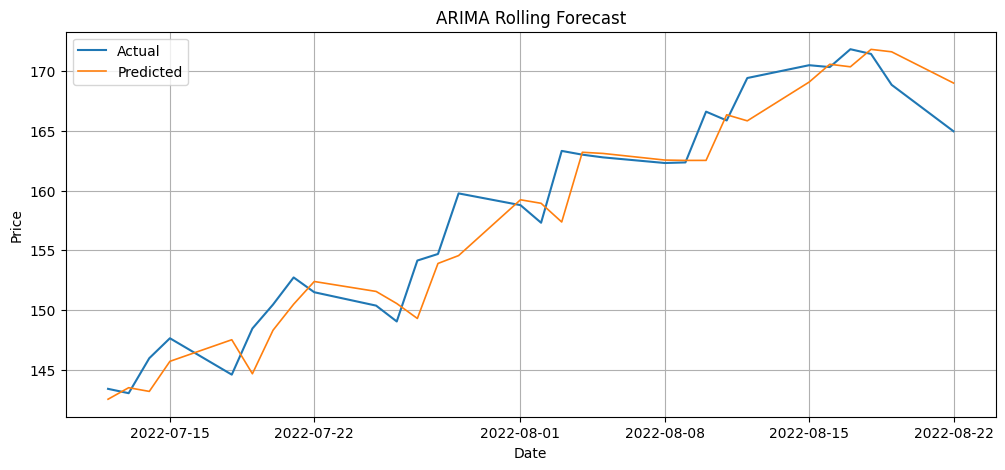

In [135]:
import matplotlib.pyplot as plt

def plot_rolling_preds(df_roll, title='Rolling Forecast vs Actual', figsize=(12,5)):
    plt.figure(figsize=figsize)
    # df_roll expected to have index = forecast_index (datetime), columns: y_true, y_pred
    plt.plot(df_roll.index, df_roll['y_true'], label='Actual', linewidth=1.5)
    plt.plot(df_roll.index, df_roll['y_pred'], label='Predicted', linewidth=1.2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_preds(df_arima_roll, title='ARIMA Rolling Forecast')

In [136]:
# Final Performance Summary Table

metrics_summary = [
    # Baseline (Naive forecast could be extended later)
    {'model': 'Naive', 'eval_type': 'normal', 'rmse': 0.0, 'mape': 0.0},

    # Normal (static) evaluation metrics
    {'model': 'ARIMA', 'eval_type': 'normal', 'rmse': arima_rmse, 'mape': arima_mape},
    {'model': 'Prophet', 'eval_type': 'normal', 'rmse': prophet_rmse, 'mape': prophet_mape},
    {'model': 'LSTM', 'eval_type': 'normal', 'rmse': lstm_rmse, 'mape': lstm_mape},

    # Rolling evaluation metrics
    {'model': 'ARIMA', 'eval_type': 'rolling', 'rmse': arima_roll_metrics.get('rmse', np.nan), 'mape': arima_roll_metrics.get('mape', np.nan)},
    {'model': 'Prophet', 'eval_type': 'rolling', 'rmse': prophet_roll_metrics.get('rmse', np.nan), 'mape': prophet_roll_metrics.get('mape', np.nan)},
]

df_metrics = pd.DataFrame(metrics_summary)[['model', 'eval_type', 'rmse', 'mape']]

# Sort by model then eval type for clarity
df_metrics.sort_values(by=['model', 'eval_type'], inplace=True)

# Replace NaN with readable placeholder if any remain
df_metrics.fillna('-', inplace=True)

display(df_metrics)

# Save to CSV
df_metrics.to_csv('final_performance_comparison.csv', index=False)


,model,eval_type,rmse,mape
1,ARIMA,normal,30.990023,0.127188
4,ARIMA,rolling,2.564938,-
3,LSTM,normal,10.225749,0.036339
0,Naive,normal,0.000000,0.0
2,Prophet,normal,33.362214,0.13636
5,Prophet,rolling,6.290585,3.248169
